<a href="https://colab.research.google.com/github/Lypsilon/GameProject/blob/main/CSTM_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSIM - Cognitive Systems, Theory and Models - Final Project**

## Comparing performances of different autoencoders in the CIFAR10 dataset

**Content creators:** Abel Briones, Lydia Fettweis, Sajad Kahali & Lorenzo Micozzi  


---
## Theoretical background

* What are autoencoders?
* Type of autoencoders
  * Autoencoders (AE)
  * Varational Autoencoders (VAE)
  * Vector Quantized Variational Autoencoder (VQ-VAE)

* CIFAR10
  * images with 3 color channels and 32x32 pixels

* Applications



---
## 1. Autoencoders (AE)

### 1.1. Setup

In [ ]:
#@title Import packages

## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Folium
# %pip install folium==0.2.1
# import folium

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    %pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cpu


In [ ]:
#@title Import pretrained models
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
#@title Loading CIFAR-10 dataset

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 1.2. Building the autoencoder

In [ ]:
#@title Implementing the encoder

class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)



In [ ]:
#@title Implementing the decoder
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
#@title Implementing the autoencoder architecture

class Autoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=20, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

### 1.1. Test

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


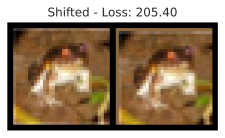

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


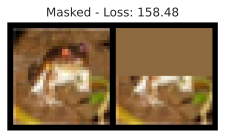

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


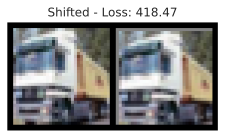

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


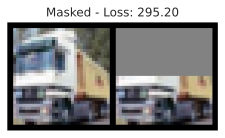

In [ ]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## 2. Varational Autoencoders (VAE)

### 2.1. Setup

In [ ]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
def encoder(input_images, latent_dim, intermediate_dim=0, reuse=False, name='varencoder'):
	with tf.variable_scope(name, reuse=reuse):

		xavier_initializer = tf.contrib.layers.xavier_initializer()

		# Convolution outputs [batch, 16, 16, 3]
		conv1 = tf.layers.conv2d(inputs=input_images,
	                             filters=3,
	                             kernel_size=4,
	                             strides=2,
	                             padding='same',
	                             kernel_initializer=xavier_initializer,
	                             activation=tf.nn.relu)

		# Convolution outputs [batch, 8, 8, 64]
		conv2 = tf.layers.conv2d(inputs=conv1,
	                             filters=64,
	                             kernel_size=4,
	                             strides=2,
	                             padding='same',
	                             kernel_initializer=xavier_initializer,
	                             activation=tf.nn.relu)

		# Convolution outputs [batch, 4, 4, 64]
		conv3 = tf.layers.conv2d(inputs=conv2,
	                             filters=64,
	                             kernel_size=4,
	                             strides=2,
	                             padding='same',
	                             kernel_initializer=xavier_initializer,
	                             activation=tf.nn.relu)

		flat = tf.contrib.layers.flatten(conv3)

		z_mean = tf.layers.dense(flat, units=latent_dim, name='z_mean')
		z_log_var = tf.layers.dense(flat, units=latent_dim, name='z_log_var')


		return z_mean, z_log_var

def decoder(z_flat, latent_dim, intermediate_dim=0, reuse=False, name='vardecoder'):
	with tf.variable_scope(name, reuse=reuse):
		xavier_initializer = tf.contrib.layers.xavier_initializer()

		# Dense outputs [batch, 4, 4, 64]
		z_develop = tf.layers.dense(z_flat, units=4*4*64)
		net = tf.nn.relu(tf.reshape(z_develop, [-1, 4, 4, 64]))

		# Transposed convolution outputs [batch, 8, 8, 64]
		net = tf.layers.conv2d_transpose(inputs=net, 
										 filters=64,
										 kernel_size=4,
										 strides=2,
										 padding='same',
                                         kernel_initializer=xavier_initializer,
                                         activation=tf.nn.relu)

		# Transposed convolution outputs [batch, 16, 16, 64]
		net = tf.layers.conv2d_transpose(inputs=net, 
										 filters=64,
										 kernel_size=4,
										 strides=2,
										 padding='same',
                                         kernel_initializer=xavier_initializer,
                                         activation=tf.nn.relu)

		# Transposed convolution outputs [batch, 32, 32, 3]
		net = tf.layers.conv2d_transpose(inputs=net, 
										 filters=3,
										 kernel_size=4,
										 strides=2,
										 padding='same',
                                         kernel_initializer=xavier_initializer)
                                        

		net = tf.nn.sigmoid(net)

		return net

### 2.2. Test

## 3. Vector Quantized Variational AutoencoderS (VQ-VAE)

### 3.1. Setup

### 3.2. Test

---
## Conclusions

## Bibliography and resources

**Theoretical background**
* Difference between AutoEncoder (AE) and Variational AutoEncoder (VAE) - [Here](https://towardsdatascience.com/difference-between-autoencoder-ae-and-variational-autoencoder-vae-ed7be1c038f2#:~:text=The%20encoder%20in%20the%20AE,to%20be%20a%20normal%20distribution.)
* CIFAR-10 Dataset - [Here](https://www.cs.toronto.edu/~kriz/cifar.html)
* https://www.tensorflow.org/tutorials/generative/cvae

**Notebooks**
* AE - https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
* VAE - https://colab.research.google.com/github/taldatech/soft-intro-vae-pytorch/blob/main/soft_intro_vae_tutorial/soft_intro_vae_image_code_tutorial.ipynb
* VQ-VAE - https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=hvOqdufj9m5-